# Pictascript

PictaScript is an image captioner. Its 'brain' calls two distinct components, working together:

- **CNNs :** To give the capacity to our computer to *'see'* images. They're in charge of idenifying the relevant elements and patterns in our image.

- **RNNs :** The RNN will give *'speaking'* capacities to our computer, taking the CNNs' informations as input to produce a sentence describing the picture *'seen'* by the CNNs, forming sentences one word at a time.

## Installing the required packages:

In [ ]:
%pip install -r requirements.txt

## Importing the required libraries:

In [2]:
# Basic libraries
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import warnings
warnings.filterwarnings('ignore')
from math import ceil
from collections import defaultdict
from tqdm.notebook import tqdm        # Progress bar library for Jupyter Notebook

# Deep learning framework for building and training models
import tensorflow as tf
## Pre-trained model for image feature extraction
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array

## Tokenizer class for captions tokenization
from tensorflow.keras.preprocessing.text import Tokenizer

## Function for padding sequences to a specific length
from tensorflow.keras.preprocessing.sequence import pad_sequences

## Class for defining Keras models
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, concatenate, Bidirectional, Dot, Activation, RepeatVector, Multiply, Lambda

# For checking score
from nltk.translate.bleu_score import corpus_bleu

# For importing the dataset
import kagglehub

# For plotting the model architecture
from keras.utils import plot_model

In [ ]:
# Download the dataset
INPUT_DIR = kagglehub.dataset_download("adityajn105/flickr8k")
print("Path to dataset files:", INPUT_DIR)
OUTPUT_DIR = 'output'

## Extracting features from Images

To save training time, we'll use the pre-trained VGG16 model. It works like an *'image interpreter'*, and can extract both simple and complex elements from images.

Extracting features out of images is key in generating sensible captions. *(= meaningful captions)*

### Loading the VGG16 model:

In [4]:
model = VGG16()

# Removing the last classification layer to see the output features of the model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

print(model.summary())

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

None


Here we extract images features and store them in a dictionnary, as this step takes quite some time, we'll later store what we've extracted in a file not to be forced to run this bit of code every time we want to access the images features.

In [5]:
# Dictionary to store image features
image_features = {}

# Get the images directory
img_dir = os.path.join(INPUT_DIR, 'Images')

In [ ]:
# Loop through each image in the directory 
# (tqdm is used for progress bar)
for img_name in tqdm(os.listdir(img_dir)):
    img_path = os.path.join(img_dir, img_name)              # Get the full path of the image
    image = load_img(img_path, target_size=(224, 224))      # Load the image with target size of 224x224 pixels
    image = img_to_array(image)                             # Convert the image to a numpy array
    
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))  # Reshape the image to match the input shape of the model
    image = preprocess_input(image)                         # Preprocess the image for VGG16
    image_feature = model.predict(image, verbose=0)         # Predict the features of the image using the model
    image_id = img_name.split('.')[0]                       # Extract the image ID from the filename
    image_features[image_id] = image_feature                # Store the image features in the dictionary

We want to store the image features in a serialized file to be able to use it without running the whole code every time we're testing stuff.

In [7]:
# Ensure the output directory exists
os.makedirs(OUTPUT_DIR, exist_ok=True)
# Store the image features in pickle
pickle.dump(image_features, open(os.path.join(OUTPUT_DIR, 'img_features.pkl'), 'wb'))

In [9]:
# Load features from pickle file
pickle_file_path = os.path.join(OUTPUT_DIR, 'img_features.pkl')
with open(pickle_file_path, 'rb') as file:
    loaded_features = pickle.load(file)

## Loading caption data

After loading images and their features, we shall load their captions (in order to train the model later on)

In [10]:
with open(os.path.join(INPUT_DIR, 'captions.txt'), 'r') as file:
    next(file)
    captions_doc = file.read()

In [ ]:
# Create mapping of image to captions
image_to_captions_mapping = defaultdict(list)

# Process lines from captions_doc
for line in tqdm(captions_doc.split('\n')):
    tokens = line.split(',')            # Split the line by comma
    if len(tokens) < 2:
        continue
    image_id, *captions = tokens
    
    image_id = image_id.split('.')[0]   # Remove extension from image ID
    caption = " ".join(captions)        # Convert captions list to string
    image_to_captions_mapping[image_id].append(caption) # Append caption to the image ID in the mapping

# Print the total number of captions
total_captions = sum(len(captions) for captions in image_to_captions_mapping.values())
print("Total number of captions:", total_captions)

## Preprocessing captions

After loading them, we shall pre-process them before inputting them in our model

In [12]:
# Function for processing the captions
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            caption = captions[i]           # Get the caption
            caption = caption.lower()       # Convert caption to lowercase
            caption = ''.join(char for char in caption if char.isalpha() or char.isspace()) # Remove punctuation and non-alphabetical characters
            caption = caption.replace('\s+', ' ') # Remove extra spaces
            caption = 'startseq ' + ' '.join([word for word in caption.split() if len(word) > 1]) + ' endseq' # Add start and end tokens to the caption
            captions[i] = caption

### Pre-process example:

In [13]:
# Before preprocess of text
image_to_captions_mapping['1026685415_0431cbf574']

['A black dog carries a green toy in his mouth as he walks through the grass .',
 'A black dog carrying something through the grass .',
 'A black dog has a blue toy in its mouth .',
 'A dog in grass with a blue item in his mouth .',
 'A wet black dog is carrying a green toy through the grass .']

In [14]:
# Preprocess the text
clean(image_to_captions_mapping)

In [15]:
# After preprocess of text
image_to_captions_mapping['1026685415_0431cbf574']

['startseq black dog carries green toy in his mouth as he walks through the grass endseq',
 'startseq black dog carrying something through the grass endseq',
 'startseq black dog has blue toy in its mouth endseq',
 'startseq dog in grass with blue item in his mouth endseq',
 'startseq wet black dog is carrying green toy through the grass endseq']

In [16]:
# Creating a List of all Captions
all_captions = [caption for captions in image_to_captions_mapping.values() for caption in captions]

# Tokenizing the Text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)

In [ ]:
# Save the tokenizer
with open('output/tokenizer.pkl', 'wb') as tokenizer_file:
    pickle.dump(tokenizer, tokenizer_file)

In [ ]:
# Load the tokenizer
with open('output/tokenizer.pkl', 'rb') as tokenizer_file:
    tokenizer = pickle.load(tokenizer_file)

In [19]:
# Calculate maximum caption length
max_caption_length = max(len(tokenizer.texts_to_sequences([caption])[0]) for caption in all_captions)
vocab_size = len(tokenizer.word_index) + 1

# Print the results
print("Vocabulary Size:", vocab_size)
print("Maximum Caption Length:", max_caption_length)

Vocabulary Size: 8768
Maximum Caption Length: 34


## Splitting the data

Time has come to split our dataset into train and test subdatasets

In [20]:
image_ids = list(image_to_captions_mapping.keys())

split = int(len(image_ids) * 0.90) # Splitting into Training and Test Sets (90% train, 10% test)
train = image_ids[:split]
test = image_ids[split:]

The `data_generator` function is designed to generate batches of training data for our image captioning model. It takes image features and their corresponding captions, tokenizes and processes each caption into input-output pairs suitable for training a sequence model. 

Specifically, it prepares three components for each training sample: the image features `(X1_batch)`, the partial input caption sequence `(X2_batch)`, and the next word in the sequence as the target `(y_batch)`.

In [25]:
# Data generator function
def data_generator(data_keys, image_to_captions_mapping, features, tokenizer, max_caption_length, vocab_size, batch_size):
    X1_batch, X2_batch, y_batch = [], [], []        # Lists to store batch data
    batch_count = 0                                 # Initialize batch counter

    # Loop indefinitely to yield batches of data
    while True:
        for image_id in data_keys: 
            captions = image_to_captions_mapping[image_id]  # Get captions for the current image

            # Loop through each caption for the current image
            for caption in captions:
                caption_seq = tokenizer.texts_to_sequences([caption])[0]    # Convert the caption to a sequence of token IDs

                # Loop through the tokens in the caption sequence
                for i in range(1, len(caption_seq)):
                    in_seq, out_seq = caption_seq[:i], caption_seq[i]               # Split the sequence into input and output pairs
                    
                    in_seq = pad_sequences([in_seq], maxlen=max_caption_length)[0]  # Pad the input sequence to the specified maximum caption length

                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]  # Convert the output sequence to one-hot encoded format

                    # Append data to batch lists
                    X1_batch.append(features[image_id][0])  # Image features
                    X2_batch.append(in_seq)  # Input sequence
                    y_batch.append(out_seq)  # Output sequence

                    batch_count += 1        # Increase the batch counter

                    # If the batch is complete, yield the batch and reset lists and counter
                    if batch_count == batch_size:
                        X1_batch, X2_batch, y_batch = np.array(X1_batch), np.array(X2_batch), np.array(y_batch)
                        yield (X1_batch, X2_batch), y_batch
                        X1_batch, X2_batch, y_batch = [], [], []
                        batch_count = 0

## Training (LSTM)

Time has come to train our model !

### Visualizing the model

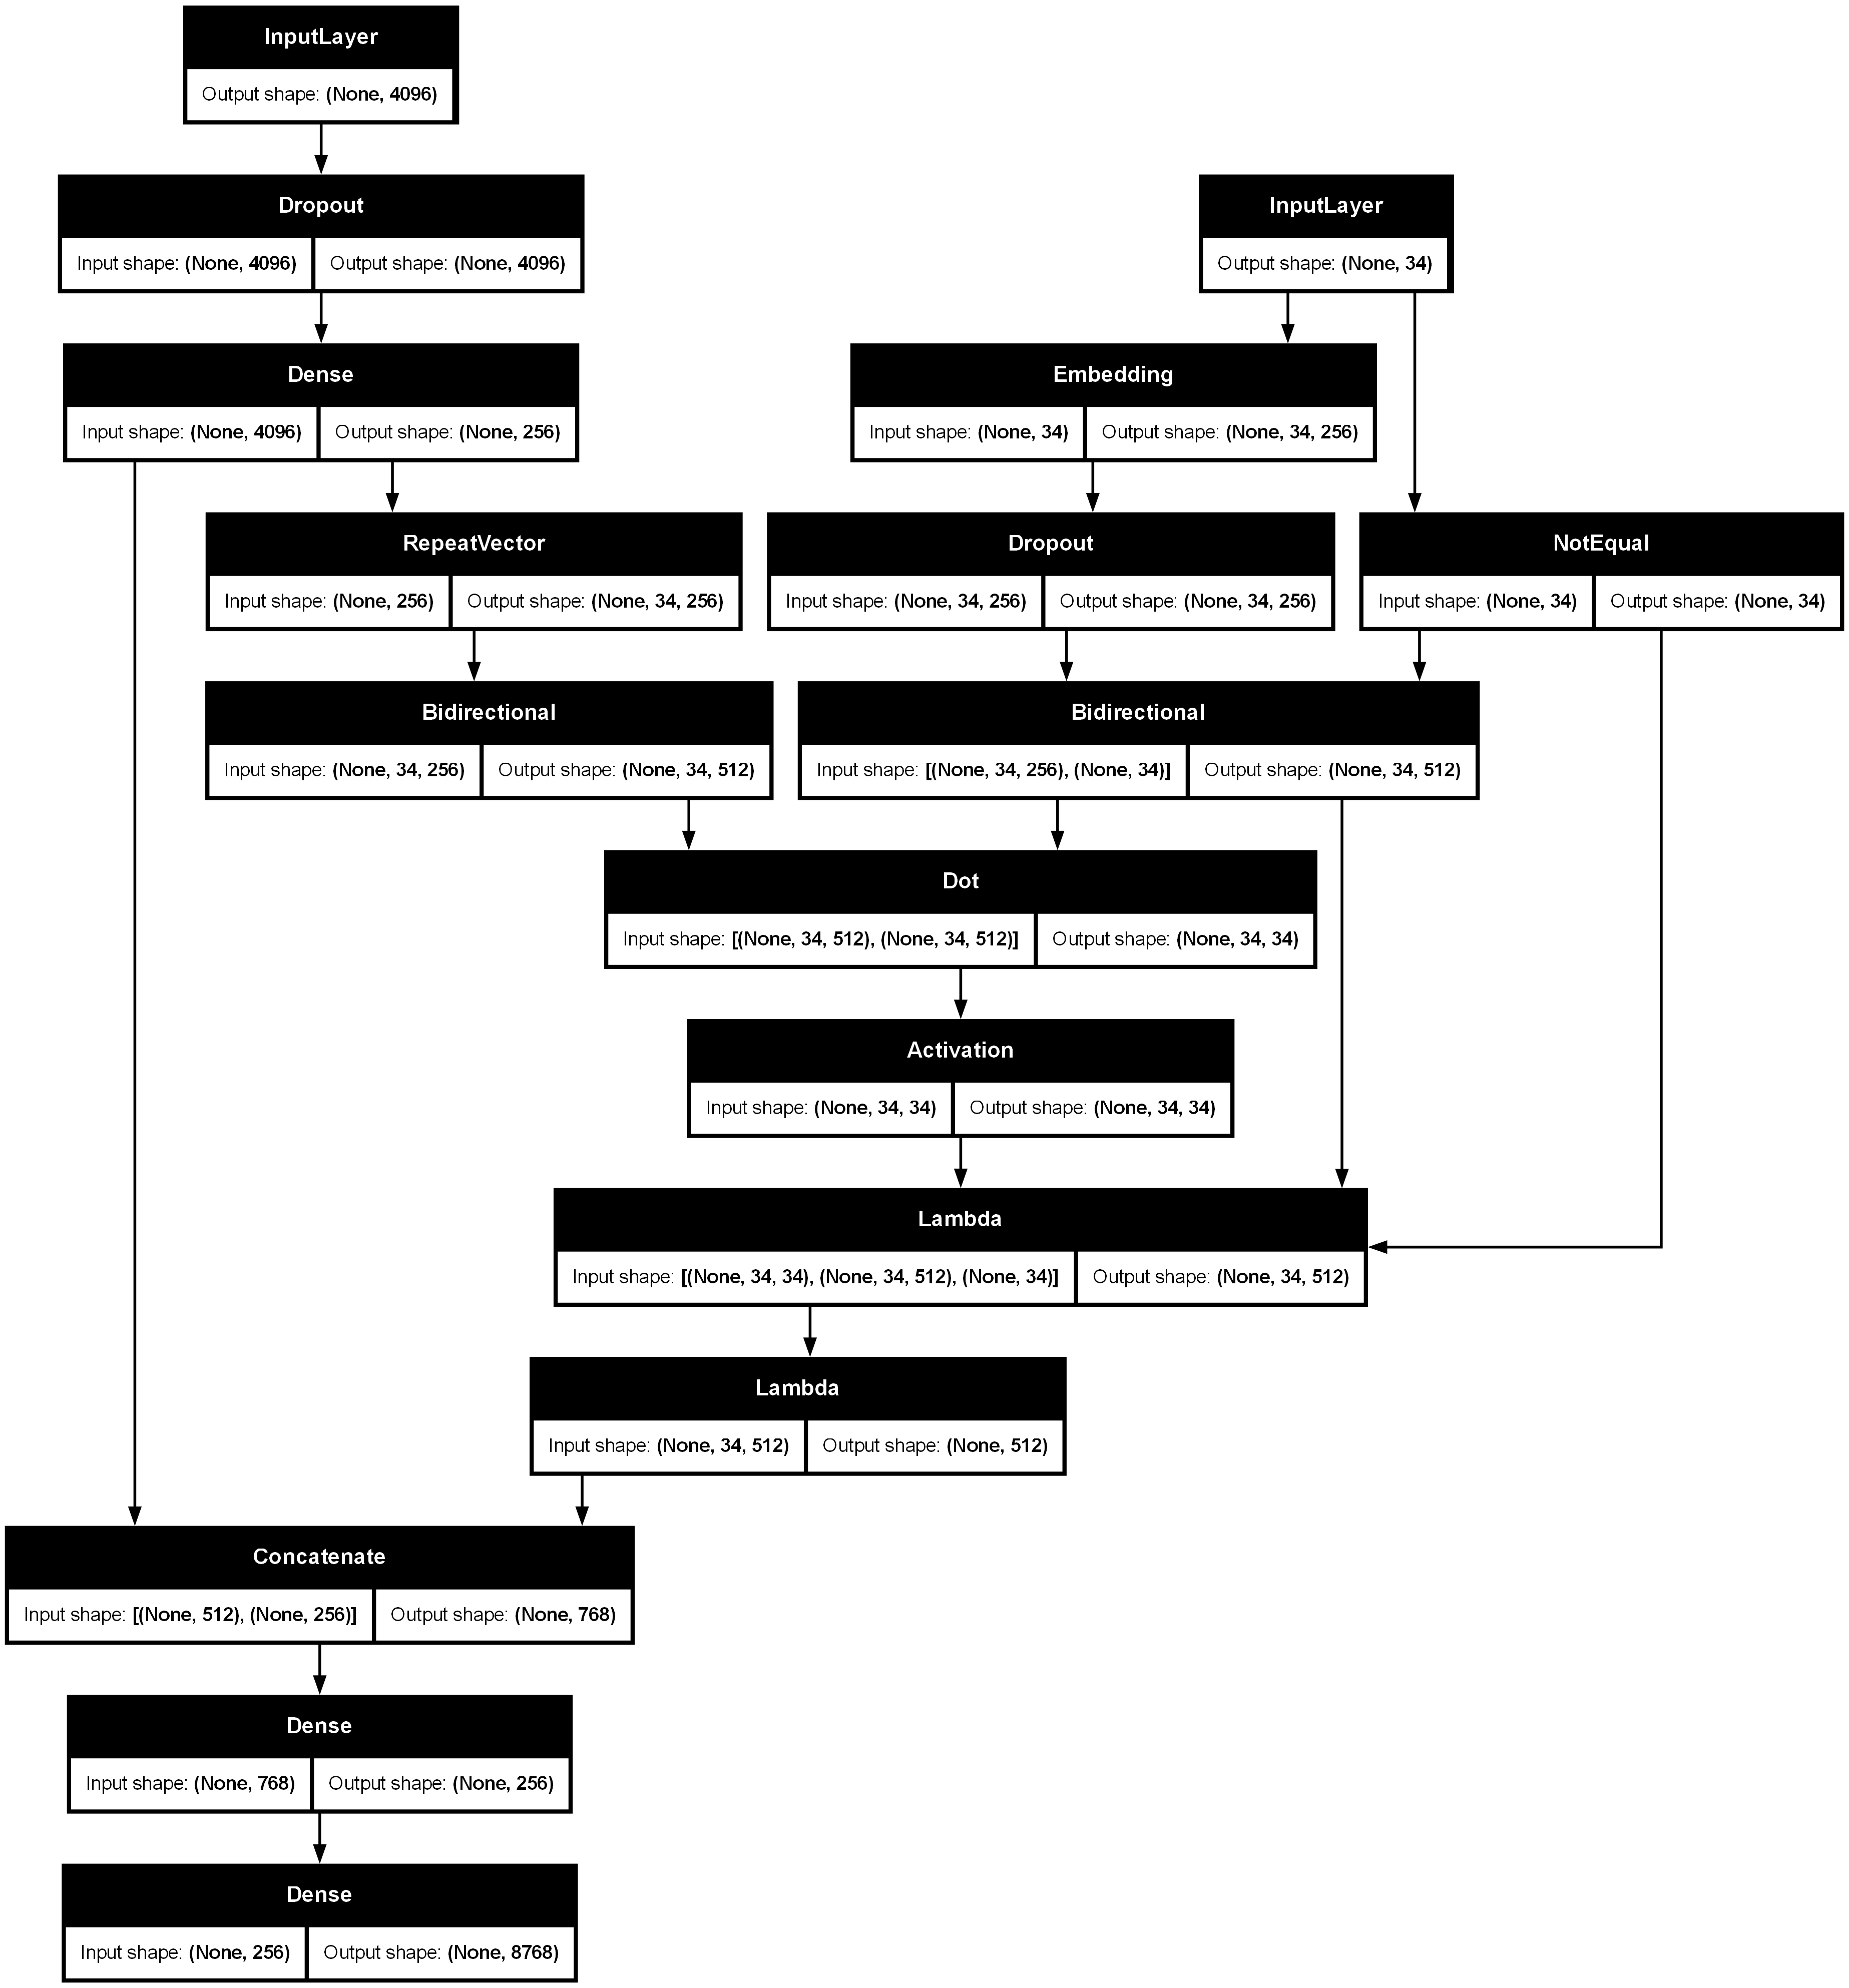

In [26]:
# Encoder model
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
fe2_projected = RepeatVector(max_caption_length)(fe2)
fe2_projected = Bidirectional(LSTM(256, return_sequences=True))(fe2_projected)

# Sequence feature layers
inputs2 = Input(shape=(max_caption_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = Bidirectional(LSTM(256, return_sequences=True))(se2)

# Apply attention mechanism using Dot product
attention = Dot(axes=[2, 2])([fe2_projected, se3])  # Calculate attention scores
attention_scores = Activation('softmax')(attention) # Softmax attention scores
attention_context = Lambda(lambda x: tf.einsum('ijk,ijl->ikl', x[0], x[1]))([attention_scores, se3]) # Apply attention scores to sequence embeddings
context_vector = Lambda(lambda x: tf.reduce_sum(x, axis=1))(attention_context) # Sum the attended sequence embeddings along the time axis

# Decoder model
decoder_input = concatenate([context_vector, fe2], axis=-1)
decoder1 = Dense(256, activation='relu')(decoder_input)
outputs = Dense(vocab_size, activation='softmax')(decoder1)

# Create the model
model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# Visualize the model
plot_model(model, show_shapes=True)

### Training !

In [27]:
# Set the number of epochs, batch size
epochs = 50
batch_size = 32

# Calculate the steps_per_epoch based on the number of batches in one epoch
steps_per_epoch = ceil(len(train) / batch_size)
validation_steps = ceil(len(test) / batch_size)  # Calculate the steps for validation data

# Loop through the epochs for training
for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    
    # Set up data generators
    train_generator = data_generator(train, image_to_captions_mapping, loaded_features, tokenizer, max_caption_length, vocab_size, batch_size)
    test_generator = data_generator(test, image_to_captions_mapping, loaded_features, tokenizer, max_caption_length, vocab_size, batch_size)
    
    model.fit(train_generator, epochs=1, steps_per_epoch=steps_per_epoch,
          validation_data=test_generator, validation_steps=validation_steps,
          verbose=1)

Epoch 1/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 48s 185ms/step - loss: 6.8076 - val_loss: 6.2856
Epoch 2/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 41s 182ms/step - loss: 5.1616 - val_loss: 6.5260
Epoch 3/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 41s 181ms/step - loss: 4.7811 - val_loss: 6.2518
Epoch 4/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 41s 181ms/step - loss: 4.3987 - val_loss: 6.3568
Epoch 5/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 42s 185ms/step - loss: 4.0419 - val_loss: 6.5354
Epoch 6/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 42s 182ms/step - loss: 3.8955 - val_loss: 6.5370
Epoch 7/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 42s 185ms/step - loss: 3.5737 - val_loss: 6.7168
Epoch 8/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 41s 180ms/step - loss: 3.3215 - val_loss: 6.5821
Epoch 9/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 41s 181ms/step - loss: 3.2186 - val_loss: 7.0072
Epoch 10/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 42s 184ms/step - loss: 2.8747 - val_loss: 6.9416
Epoch 11/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 41s 182ms/step - loss: 2.6477 - val_loss: 7.0225
Epoch 12/50
228/228

In [28]:
# Save the model
model.save(OUTPUT_DIR+'/mymodel.h5')

## Caption Generation

Now that the model is trained, we can start generating captions !

First we'll test the feature and get scores out of it.

In [29]:
def get_word_from_index(index, tokenizer):
    return next((word for word, idx in tokenizer.word_index.items() if idx == index), None)

In [30]:
def predict_caption(model, image_features, tokenizer, max_caption_length):
    # Initialize the caption sequence
    caption = 'startseq'
    
    # Generate the caption
    for _ in range(max_caption_length):
        sequence = tokenizer.texts_to_sequences([caption])[0]                   # Convert the current caption to a sequence of token indices
        sequence = pad_sequences([sequence], maxlen=max_caption_length)         # Pad the sequence to match the maximum caption length
        yhat = model.predict([image_features, sequence], verbose=0)             # Predict the next word's probability distribution
        predicted_index = np.argmax(yhat)                                       # Get the index with the highest probability
        predicted_word = get_word_from_index(predicted_index, tokenizer)        # Convert the index to a word
        caption += " " + predicted_word                                         # Append the predicted word to the caption
        
        # Stop if the word is None or if the end sequence tag is encountered
        if predicted_word is None or predicted_word == 'endseq':
            break
    
    return caption

In [31]:
# Initialize lists to store actual and predicted captions
actual_captions_list = []
predicted_captions_list = []

# Loop through the test data
for key in tqdm(test):
    
    actual_captions = image_to_captions_mapping[key]                # Get actual captions for the current image
    predicted_caption = predict_caption(model, loaded_features[key], tokenizer, max_caption_length)     # Predict the caption for the image using the model
    actual_captions_words = [caption.split() for caption in actual_captions]    # Split actual captions into words
    predicted_caption_words = predicted_caption.split()     # Split predicted caption into words
    
    # Append to the lists
    actual_captions_list.append(actual_captions_words)
    predicted_captions_list.append(predicted_caption_words)

# Calculate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual_captions_list, predicted_captions_list, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual_captions_list, predicted_captions_list, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.441421
BLEU-2: 0.191189


## Caption generation

Now we can try and generate captions from our own images, or images from the dataset and compare.

In [ ]:
def generate_caption_from_dataset(image_name):
    # load the image
    image_id = image_name.split('.')[0]
    img_path = os.path.join(INPUT_DIR, "Images", image_name)
    image = Image.open(img_path)
    captions = image_to_captions_mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, loaded_features[image_id], tokenizer, max_caption_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

In [48]:
# Load the pre-trained VGG16 model for feature extraction
feature_model = VGG16()
feature_model = Model(inputs=feature_model.inputs, outputs=feature_model.layers[-2].output)

def extract_features(img_path):
    img = load_img(img_path, target_size=(224, 224))  # Resize the image to fit VGG16 input size
    img = img_to_array(img)  # Convert image to array
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    img = preprocess_input(img)  # Preprocess the image for VGG16
    features = feature_model.predict(img, verbose=0)  # Extract features
    return features

def generate_caption_from_own(img_path):
    # Extract features from the image
    image_features = extract_features(img_path)
    
    # Predict the caption using the model
    caption = predict_caption(model, image_features, tokenizer, max_caption_length)
    
    # Display the image and its predicted caption
    image = Image.open(img_path)
    plt.imshow(image)
    print(caption)

### Image from the dataset, with comparison

In [ ]:
generate_caption_from_dataset("1032460886_4a598ed535.jpg")

In [ ]:
generate_caption_from_dataset("1032122270_ea6f0beedb.jpg")

### Own image

In [ ]:
generate_caption_from_own("./SampleImages/sample1.jpg")

In [ ]:
generate_caption_from_own("./SampleImages/sample2.jpg")